# Phase 1: Data Cleaning & Preprocessing



**Objective**: Prepare the raw Google Play Store and Apple App Store datasets for analysis.

**Why is this important?**
Real-world data is messy. It contains duplicates, missing values, and inconsistent formats (e.g., "10M" vs "10000"). 
Machine Learning models cannot handle these inconsistencies. 
In this notebook, we will:
1.  Load the datasets.
2.  Inspect the data structure (Rows, Columns, Data Types).
3.  Handle Missing Values (Imputation vs Dropping).
4.  Clean and Standardize columns (Size, Installs, Price).
5.  Unify the schemas to allow comparison.
    


## 1. Import Libraries


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')


## 2. Load Datasets


In [17]:
# Robust data loading
import os
def get_data_path(filename):
    possible_paths = [
        f"../data/{filename}", # If running from notebooks/
        f"data/{filename}",    # If running from root
        f"/Users/jatinbisen/Desktop/Data_mining/data/{filename}" # Absolute path
    ]
    for path in possible_paths:
        if os.path.exists(path):
            return path
    return None

google_path = get_data_path('Google-Playstore.csv')
apple_path = get_data_path('appleAppData.csv')

if google_path and apple_path:
    google_df = pd.read_csv(google_path)
    apple_df = pd.read_csv(apple_path)
    print("Datasets loaded successfully!")
    print(f"Google Play Data Shape: {google_df.shape}")
    print(f"Apple Store Data Shape: {apple_df.shape}")
else:
    print("Error: Datasets not found. Please ensure they are in the 'data/' directory.")


Datasets loaded successfully!
Google Play Data Shape: (2312944, 24)
Apple Store Data Shape: (1230376, 21)


## 3. Google Play Store Data Cleaning



### 3.1 Inspection
Let's look at the first few rows and the data types.
    


In [18]:
google_df.head()


,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,USD,10M,7.1 and up,Jean Confident Irénée NIYIZIBYOSE,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,USD,2.9M,5.0 and up,Webserveis,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,USD,3.7M,4.0.3 and up,Cabin Crew,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,USD,1.8M,4.0.3 and up,Climate Smart Tech2,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,USD,6.2M,4.1 and up,Rafal Milek-Horodyski,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


In [19]:
google_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   App Name           object 
 1   App Id             object 
 2   Category           object 
 3   Rating             float64
 4   Rating Count       float64
 5   Installs           object 
 6   Minimum Installs   float64
 7   Maximum Installs   int64  
 8   Free               bool   
 9   Price              float64
 10  Currency           object 
 11  Size               object 
 12  Minimum Android    object 
 13  Developer Id       object 
 14  Developer Website  object 
 15  Developer Email    object 
 16  Released           object 
 17  Last Updated       object 
 18  Content Rating     object 
 19  Privacy Policy     object 
 20  Ad Supported       bool   
 21  In App Purchases   bool   
 22  Editors Choice     bool   
 23  Scraped Time       object 
dtypes: bool(4), float64(4), int64(1), object(15)
memor


### 3.2 Handling Duplicates
Duplicate entries can skew our analysis. We should remove them based on the App Name.
    


In [20]:
# Check for duplicates
duplicates = google_df.duplicated(subset=['App Name']).sum()
print(f"Number of duplicate apps in Google Play: {duplicates}")

# Drop duplicates
google_df.drop_duplicates(subset=['App Name'], inplace=True)
print(f"Shape after dropping duplicates: {google_df.shape}")


Number of duplicate apps in Google Play: 135000
Shape after dropping duplicates: (2177944, 24)



### 3.3 Cleaning Columns
We noticed several issues:
- **Installs**: Contains '+' and ',' (e.g., "10,000+"). Needs to be numeric.
- **Size**: Contains 'M', 'k', 'G'. Needs to be converted to bytes (float).
- **Price**: Contains '$'. Needs to be numeric.
    


In [21]:
# Function to clean Installs
def clean_installs(val):
    if isinstance(val, str):
        val = val.replace('+', '').replace(',', '')
        try:
            return int(val)
        except ValueError:
            return np.nan
    return val

google_df['Installs'] = google_df['Installs'].apply(clean_installs)
print("Installs cleaned.")


Installs cleaned.


In [22]:
# Function to clean Size
def clean_size(size):
    size = str(size).strip()
    if 'M' in size:
        return float(size.replace('M', '').replace(',', '')) * 1024 * 1024
    elif 'k' in size:
        return float(size.replace('k', '').replace(',', '')) * 1024
    elif 'G' in size:
        return float(size.replace('G', '').replace(',', '')) * 1024 * 1024 * 1024
    else:
        return np.nan # Treat 'Varies with device' as NaN

google_df['Size'] = google_df['Size'].apply(clean_size)
print("Size cleaned.")


Size cleaned.


In [23]:
# Clean Price (if needed, usually it's already numeric in this dataset but good to check)
# The dataset might have 'Free' as a boolean and Price as 0. Let's check.
print(google_df['Price'].unique()[:10])
google_df['Price'] = pd.to_numeric(google_df['Price'], errors='coerce')
print("Price cleaned.")


[ 0.    1.99  4.99  0.99  2.99  3.49 24.99  4.49  3.99 99.99]
Price cleaned.



### 3.4 Handling Missing Values
Let's visualize missing values.
    


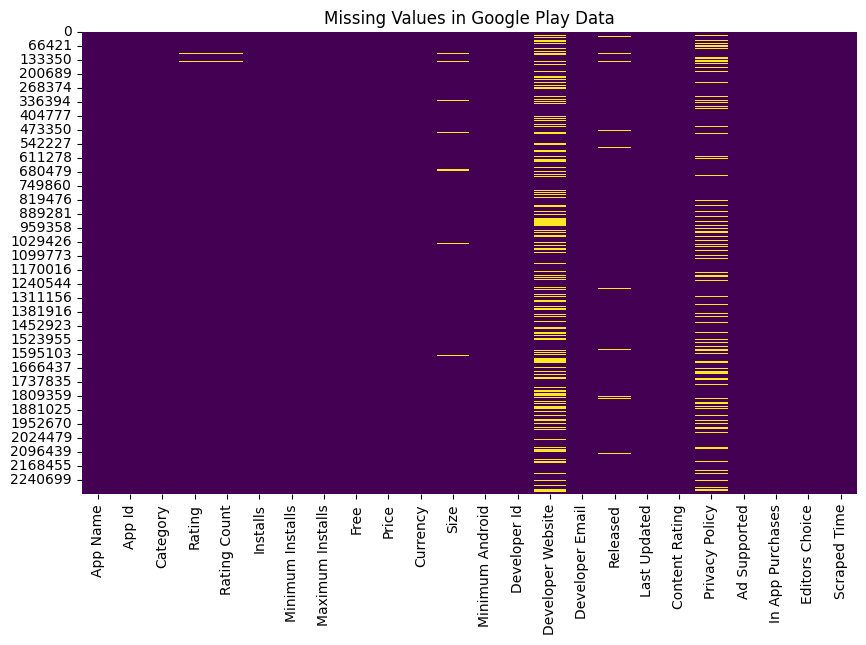

App Name                  1
App Id                    0
Category                  0
Rating                21568
Rating Count          21568
Installs                107
Minimum Installs        107
Maximum Installs          0
Free                      0
Price                     0
Currency                135
Size                  71369
Minimum Android        6241
Developer Id             33
Developer Website    698325
Developer Email          30
Released              68607
Last Updated              0
Content Rating            0
Privacy Policy       390898
Ad Supported              0
In App Purchases          0
Editors Choice            0
Scraped Time              0
dtype: int64


In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(google_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Google Play Data')
plt.show()

print(google_df.isnull().sum())



**Strategy**:
- **Rating**: Critical for analysis. We can drop rows without ratings or impute with category mean. Given the size of data, dropping is safe.
- **Size**: 'Varies with device' resulted in NaNs. We can impute with the mean size of the Category.
    


In [25]:
# Drop rows where Rating, App Name, or Category is missing
google_df.dropna(subset=['App Name', 'Category', 'Rating', 'Installs'], inplace=True)

# Impute missing Size with Category mean
google_df['Size'] = google_df.groupby('Category')['Size'].transform(lambda x: x.fillna(x.mean()))

print(f"Shape after handling missing values: {google_df.shape}")


Shape after handling missing values: (2156375, 24)


## 4. Apple App Store Data Cleaning


Similar process for iOS data.


In [26]:
apple_df.head()


,App_Id,App_Name,AppStore_Url,Primary_Genre,Content_Rating,Size_Bytes,Required_IOS_Version,Released,Updated,Version,Price,Currency,Free,DeveloperId,Developer,Developer_Url,Developer_Website,Average_User_Rating,Reviews,Current_Version_Score,Current_Version_Reviews
0,com.hkbu.arc.apaper,A+ Paper Guide,https://apps.apple.com/us/app/a-paper-guide/id...,Education,4+,21993472.0,8.0,2017-09-28T03:02:41Z,2018-12-21T21:30:36Z,1.1.2,0.00,USD,True,1375410542,HKBU ARC,https://apps.apple.com/us/developer/hkbu-arc/i...,NaN,0.0,0,0.0,0
1,com.dmitriev.abooks,A-Books,https://apps.apple.com/us/app/a-books/id103157...,Book,4+,13135872.0,10.0,2015-08-31T19:31:32Z,2019-07-23T20:31:09Z,1.3,0.00,USD,True,1031572001,Roman Dmitriev,https://apps.apple.com/us/developer/roman-dmit...,NaN,5.0,1,5.0,1
2,no.terp.abooks,A-books,https://apps.apple.com/us/app/a-books/id145702...,Book,4+,21943296.0,9.0,2021-04-14T07:00:00Z,2021-05-30T21:08:54Z,1.3.1,0.00,USD,True,1457024163,Terp AS,https://apps.apple.com/us/developer/terp-as/id...,NaN,0.0,0,0.0,0
3,fr.antoinettefleur.Book1,A-F Book #1,https://apps.apple.com/us/app/a-f-book-1/id500...,Book,4+,81851392.0,8.0,2012-02-10T03:40:07Z,2019-10-29T12:40:37Z,1.2,2.99,USD,False,439568839,i-editeur.com,https://apps.apple.com/us/developer/i-editeur-...,NaN,0.0,0,0.0,0
4,com.imonstersoft.azdictionaryios,A-Z Synonyms Dictionary,https://apps.apple.com/us/app/a-z-synonyms-dic...,Reference,4+,64692224.0,9.0,2020-12-16T08:00:00Z,2020-12-18T21:36:11Z,1.0.1,0.00,USD,True,656731821,Ngov chiheang,https://apps.apple.com/us/developer/ngov-chihe...,http://imonstersoft.com,0.0,0,0.0,0


In [27]:
# Rename columns for consistency
apple_df = apple_df.rename(columns={
    'App_Name': 'App',
    'Primary_Genre': 'Category',
    'Average_User_Rating': 'Rating',
    'Rating_Count': 'Reviews',
    'Price': 'Price',
    'Size_Bytes': 'Size',
    'Content_Rating': 'Content_Rating'
})

# Drop duplicates
apple_df.drop_duplicates(subset=['App'], inplace=True)

# Filter for relevant columns
# Note: Apple dataset might not have 'Installs'. We will use 'Reviews' (Rating Count) as a proxy for popularity later.
apple_df = apple_df[['App', 'Category', 'Rating', 'Reviews', 'Price', 'Size', 'Content_Rating']]

# Handle Missing Values
apple_df.dropna(subset=['App', 'Category', 'Rating'], inplace=True)

print(f"Apple Data Shape after cleaning: {apple_df.shape}")


Apple Data Shape after cleaning: (1223510, 7)


## 5. Unifying Schemas


To compare them, we need a common structure.


In [28]:
# Add Platform column
google_df['Platform'] = 'Android'
apple_df['Platform'] = 'iOS'

# Rename Google columns to match
google_df = google_df.rename(columns={
    'App Name': 'App',
    'Rating Count': 'Reviews',
    'Content Rating': 'Content_Rating'
})

# Select common columns
common_cols = ['App', 'Category', 'Rating', 'Reviews', 'Size', 'Price', 'Content_Rating', 'Platform', 'Installs']

# Add missing columns to Apple (Installs)
apple_df['Installs'] = np.nan

# Ensure Google has all columns
google_final = google_df[common_cols].copy()
apple_final = apple_df[common_cols].copy()

# Combine
combined_df = pd.concat([google_final, apple_final], ignore_index=True)
print(f"Combined Dataset Shape: {combined_df.shape}")


Combined Dataset Shape: (3379885, 9)


## 6. Save Cleaned Data


In [29]:
# Robust output path
import os
def get_output_path(filename):
    # If running from notebooks/, go up one level
    if os.path.basename(os.getcwd()) == 'notebooks':
        base_dir = '..'
    else:
        base_dir = '.'
        
    output_dir = os.path.join(base_dir, 'output')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    return os.path.join(output_dir, filename)

google_final.to_csv(get_output_path('google_cleaned.csv'), index=False)
apple_final.to_csv(get_output_path('apple_cleaned.csv'), index=False)
combined_df.to_csv(get_output_path('combined_cleaned.csv'), index=False)

print(f"Cleaned datasets saved to {get_output_path('')}")


Cleaned datasets saved to ../output/
